### Modularity clustering
This code follows from Mark Newman 2006 (publications) 

We start with some basic imports:

In [1]:
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt

Next, create a symmetric matrix with two random communities for testing purposes:


In [2]:
def sym_rand_community(n, m, pn = 0.9, pm = 0.9, pnm = 0.1):
    mat = np.zeros((n + m, n + m))
    for i in range(0, n):
        for j in range(0, i):
            mat[i, j] = 1 if np.random.random_sample() < pn else 0
            mat[j, i] = mat[i, j]
    for i in range(n, n + m):
        for j in range(n, i):
            mat[i, j] = 1 if np.random.random_sample() < pm else 0
            mat[j, i] = mat[i, j]
    for i in range(0, n):
        for j in range(n, n + m):
            mat[i, j] = 1 if np.random.random_sample() < pnm else 0
            mat[j, i] = mat[i, j]
    return mat


In [3]:
adj = sym_rand_community(50, 30, 0.3, 0.3, 0.001)

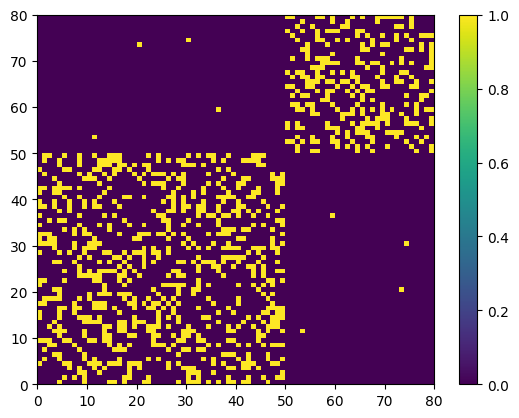

In [4]:
plt.pcolormesh(adj)
plt.colorbar()

## Now we try to implement the code in the paper (2006a). 

First calculate the modularity matrix:

In [5]:
def calculate_modularity_mat(adj): 
    # initialize matrix
    n = np.shape(adj)[0]
    mod_mat = np.zeros((n, n))

    # calculate total edges in matrix:
    m2 = np.sum(adj) # actually twice the number of edges!
    deg = np.zeros(n)
    for i in range(n):
        deg[i] = np.sum(adj[i, :])
    
    mod_mat = adj - np.outer(deg, deg) / m2
    
    return mod_mat

In [6]:
test = np.array([1, 2, 3])
res = np.outer(test, test)
res

array([[1, 2, 3],
       [2, 4, 6],
       [3, 6, 9]])

In [7]:
mod_mat = calculate_modularity_mat(adj)

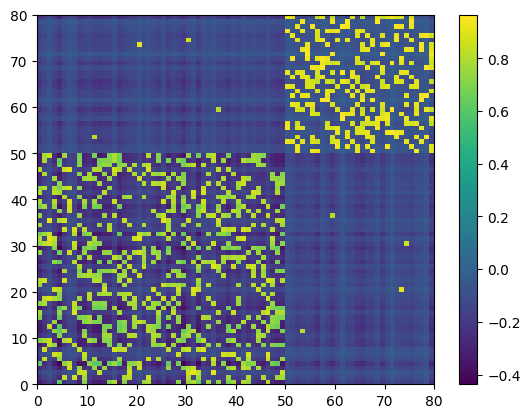

In [8]:
# visualization of modularity matrix
plt.pcolormesh(mod_mat)
plt.colorbar()

Next, calculate the eigenvalues and eigenvectors. Then split into communities based on the signs of the largest eigenvector. 

In [9]:
ews, evs = np.linalg.eig(mod_mat)

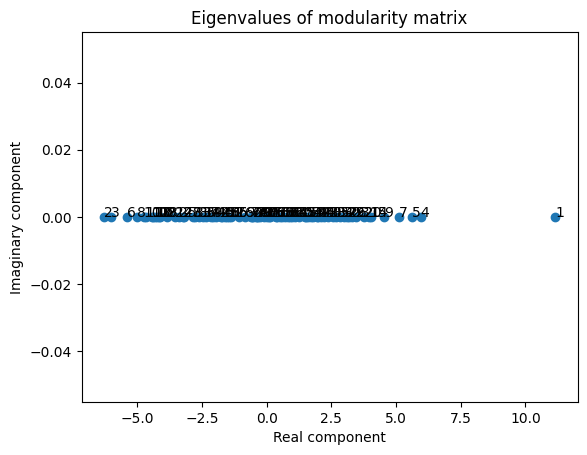

In [10]:
# plot eigenvalues of modularity matrix
fig, ax = plt.subplots()
ax.scatter(ews.real, ews.imag)
ax.set_title("Eigenvalues of modularity matrix")
ax.set_xlabel("Real component")
ax.set_ylabel("Imaginary component")

# optional: label each eigenvalue (sorted from largest magnitude to smallest)
n = np.size(ews)
for i in range(n):
    ax.annotate(i + 1, (ews[i].real, ews[i].imag))

In [11]:
# get signs of largest eigenvector
s = np.zeros(n)
for i in range(n):
    s[i] = 1 if evs[i, 0] > 0 else -1 
s

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.])

In [12]:
idx1 = s == 1
idx2 = s == -1

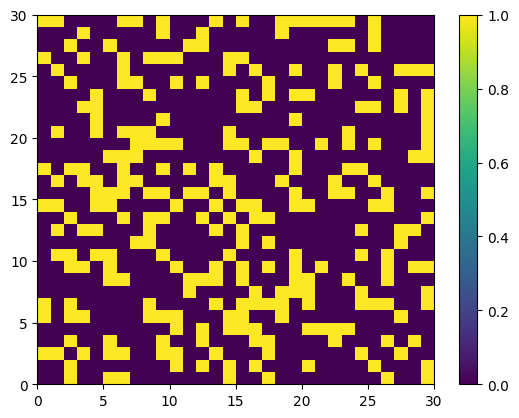

In [13]:
# note here index can be for any group
plt.pcolormesh(adj[idx1, :][:, idx1])
plt.colorbar()

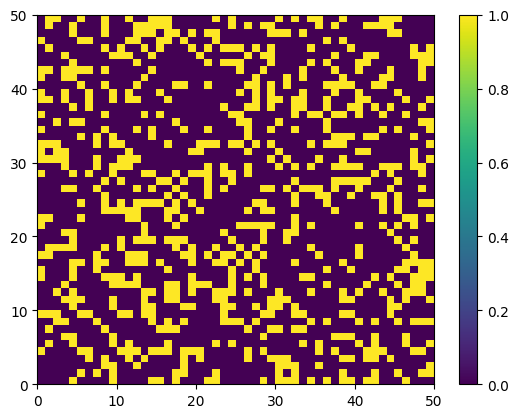

In [14]:
plt.pcolormesh(adj[idx2, :][:, idx2])
plt.colorbar()